# Use the markers across the wall to see if the disparity is same as the edges

In [1]:
import numpy as np
import depthai as dai
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
aruco_dictionary = aruco.Dictionary_get(aruco.DICT_4X4_1000)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.00001)

def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    plt.figure(figsize=(12, 8))
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.imshow(image)


def display_overlay_points(left_pts, right_pts, markerSize = 20, setSize = True):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    if setSize:
        plt.xlim(0, size[0])
        plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

def detectMarkers(image_rgb):
    image = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    marker_corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
    # print(f'Shape of markers corners => {(rejectedImgPoints)}')
    
    marker_corners_list = []
    for marker in marker_corners:
        marker_corners_list.append(marker[-1])
    marker_corners_list = np.asarray(marker_corners_list).reshape(-1, 2)
    cv2.cornerSubPix(image, marker_corners_list, (3,3), (-1,-1), criteria)
    return marker_corners_list, ids

def display_overlay_points(left_pts, right_pts, markerSize = 20):
    plt.figure(figsize=(12, 8))
    plt.rcParams["figure.autolayout"] = True
    plt.xlim(0, size[0])
    plt.ylim(0, size[1])
    plt.grid()

    x = left_pts[0, :, 0]
    y = left_pts[0, :, 1]
    color = "blue"
    plt.scatter(x, y, c=color, s = markerSize)

    x = right_pts[0, :, 0]
    y = right_pts[0, :, 1]
    color = "red"
    plt.scatter(x, y, c=color, s = markerSize)


    # ?plt.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
    plt.show()

In [3]:
size = (1920, 1200)

calibration_handler = dai.CalibrationHandler('./calib_sensor_07_051923.json')
M_left = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoLeftCameraId(), size[0], size[1]))
M_right = np.array(calibration_handler.getCameraIntrinsics(calibration_handler.getStereoRightCameraId(), size[0], size[1]))
D_left = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoLeftCameraId()))
D_right = np.array(calibration_handler.getDistortionCoefficients(calibration_handler.getStereoRightCameraId()))

transform = np.array(calibration_handler.getCameraExtrinsics(calibration_handler.getStereoRightCameraId(), calibration_handler.getStereoLeftCameraId())) 

left_rot_right = transform[:3, :3]
left_t_right = transform[:3, 3]
# Left is basically the origin here so
origin_rot_right = left_rot_right
origin_t_right = left_t_right
origin_rot_left = np.eye(3, dtype = np.float32)

R1 = np.array(calibration_handler.getStereoLeftRectificationRotation())
R2 = np.array(calibration_handler.getStereoRightRectificationRotation())

if 0:
    roll = 0
    pitch = 20 
    yaw = 0
    left_translation = np.array([5.0, 0.0, 0.0])
    rot_euler = R.from_euler('XYZ', [roll, pitch, yaw], degrees=True)
    cam_rot_matrix = rot_euler.as_matrix()
    
    rotation_matrix_4x4 = np.eye(4)
    rotation_matrix_4x4[:3, :3] = cam_rot_matrix
    rotation_matrix_4x4[0, 3] = left_translation[0]
    rotated_se3_matrix = transform @ rotation_matrix_4x4

    # Left is basically the origin here but rotated 20 deg. 
    origin_rot_right = rotated_se3_matrix[:3, :3]
    origin_t_right = rotated_se3_matrix[:3, 3]
    origin_rot_left = cam_rot_matrix
    
    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)
else:
    left_translation = np.array([0.0, 0.0, 0.0])

    origin_rvec_left, _ = cv2.Rodrigues(origin_rot_left)
    origin_rvec_right, _ = cv2.Rodrigues(origin_rot_right)

    # transform
    


M_focal = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(M_right, D_right, size, np.eye(3), fov_scale=1.1)
mapXL, mapYL = cv2.fisheye.initUndistortRectifyMap(M_left, D_left[:4], R1, M_focal, size, cv2.CV_32FC1)
mapXR, mapYR = cv2.fisheye.initUndistortRectifyMap(M_right, D_right[:4], R2, M_focal, size, cv2.CV_32FC1)


(1200, 1920, 3)


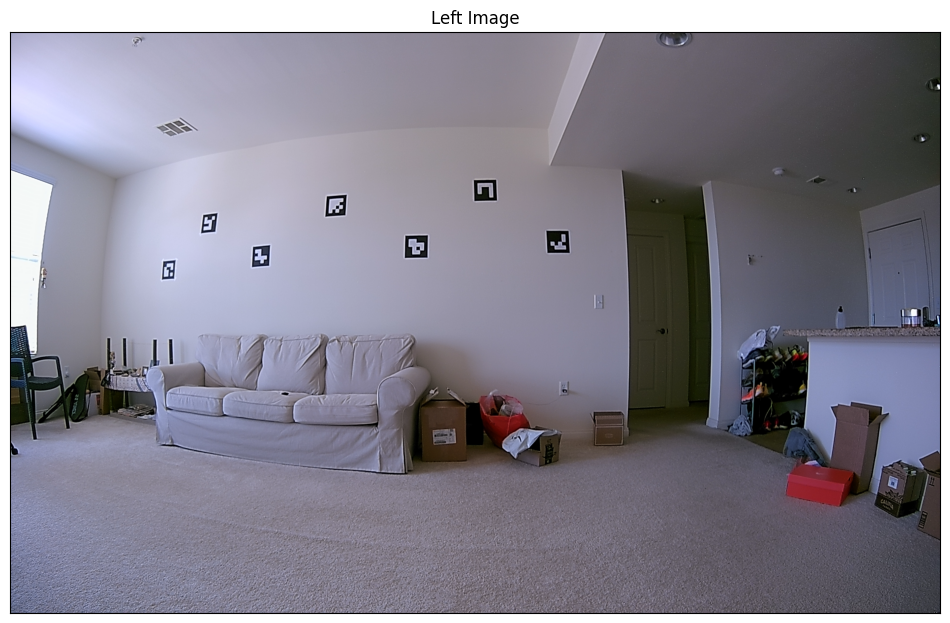

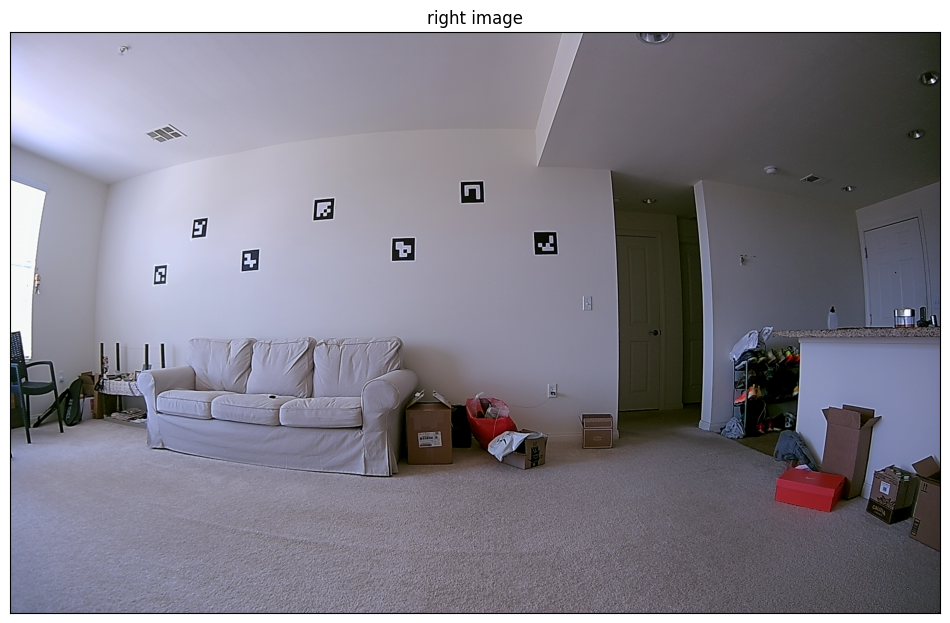

In [4]:
folder_name = 'dataset_07_aruco_16_may_3.47'
left_image = cv2.imread(folder_name + '/left/left_p0_0.png')
right_image = cv2.imread(folder_name + '/right/right_p0_0.png')
show_rgb_image(left_image, 'Left Image')
show_rgb_image(right_image, 'right image')
print(left_image.shape)

## Original markers

PS: position of the points in the plot would be inverted upside down relative to the image

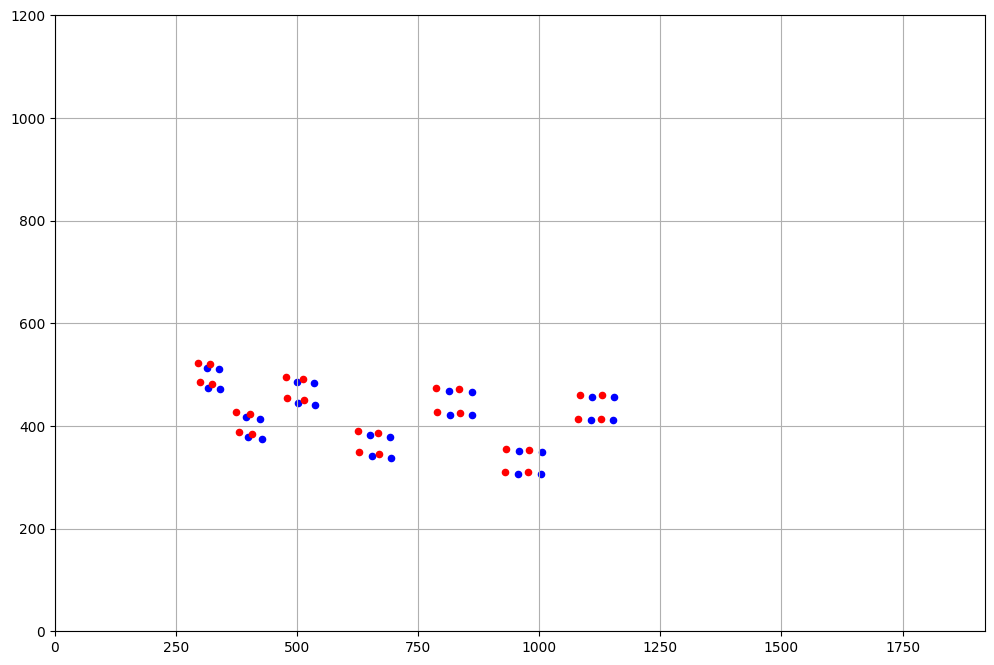

In [5]:
left_markers, left_ids = detectMarkers(left_image)
right_markers, right_ids = detectMarkers(right_image)
display_overlay_points(left_markers[None], right_markers[None])

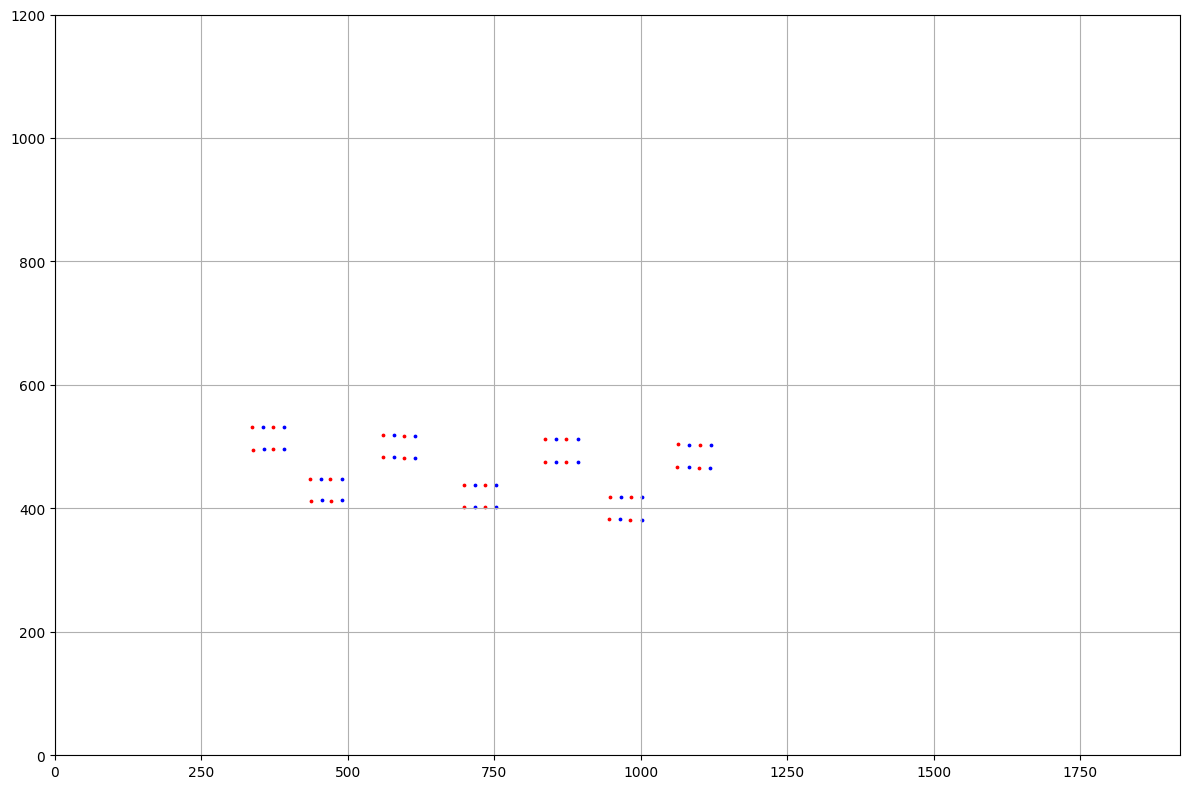

In [6]:
left_rectify_points = cv2.fisheye.undistortPoints(left_markers[None], M_left, D_left, R = R1, P = M_focal)
right_rectify_points = cv2.fisheye.undistortPoints(right_markers[None], M_right, D_right, R = R2, P = M_focal)
display_overlay_points(left_rectify_points, right_rectify_points, 3)

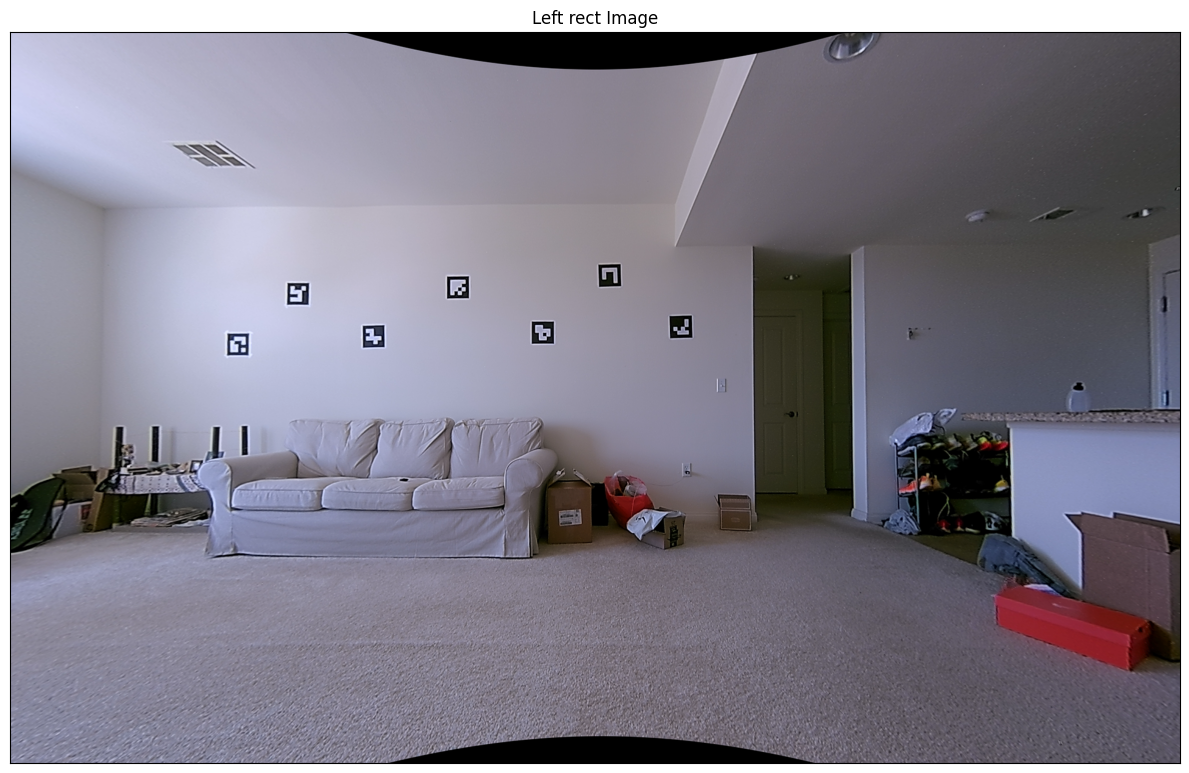

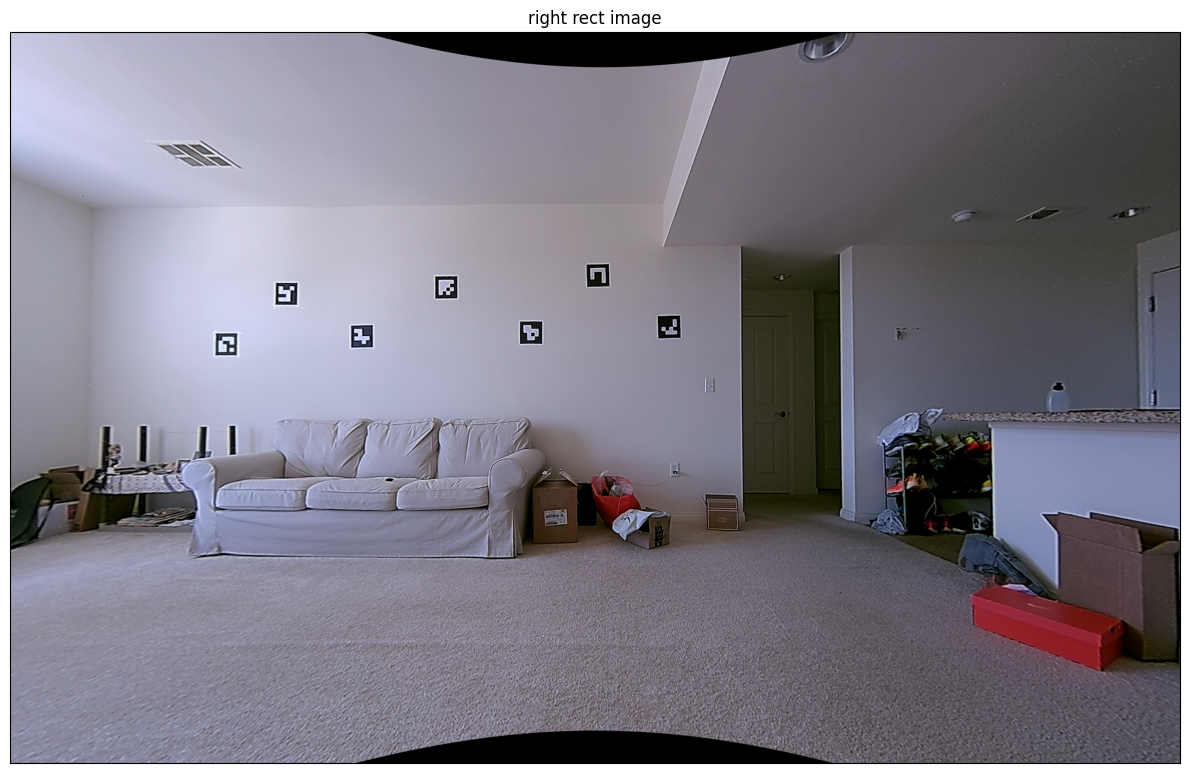

In [7]:
left_rect = cv2.remap(left_image , mapXL, mapYL, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
right_rect = cv2.remap(right_image, mapXR, mapYR, cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
show_rgb_image(left_rect, 'Left rect Image')
show_rgb_image(right_rect, 'right rect image')

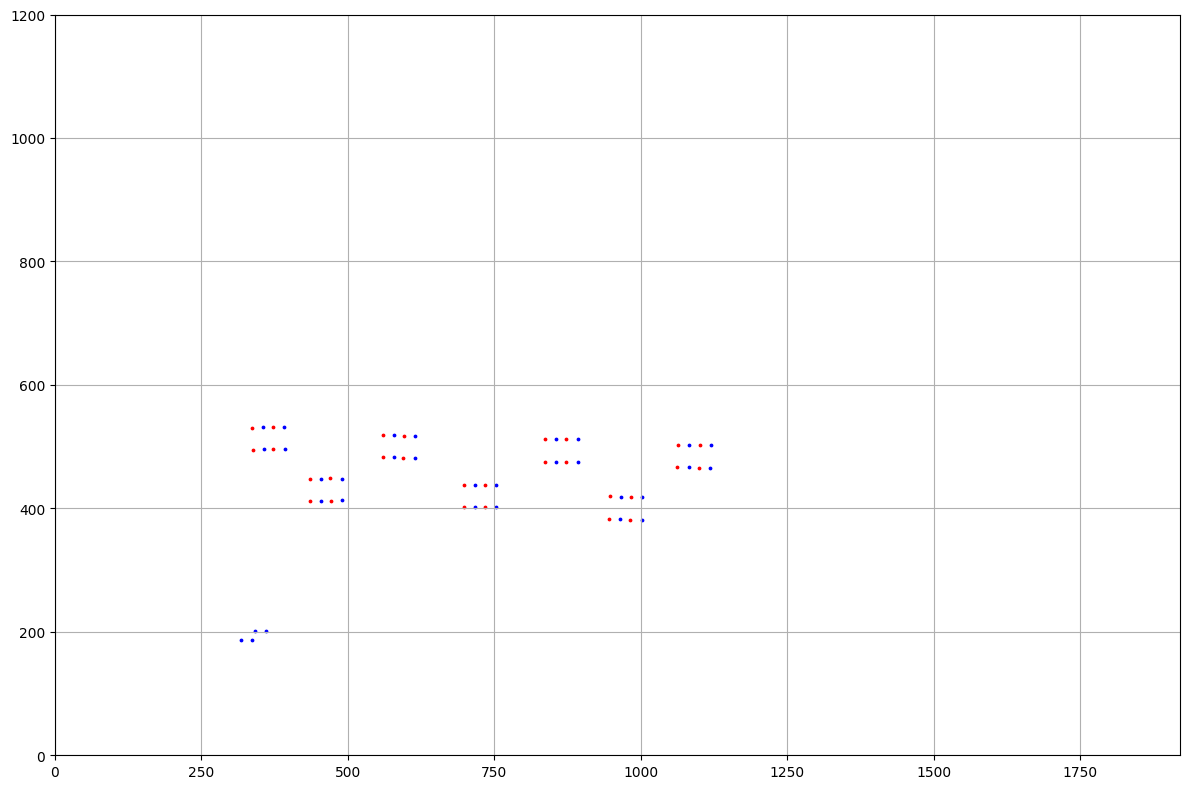

In [8]:
left_indirect_rectify_points, left_ids_indirect = detectMarkers(left_rect)
right_indirect_rectify_points, right_ids_indirect = detectMarkers(right_rect)
display_overlay_points(left_indirect_rectify_points[None], right_indirect_rectify_points[None], 3)

## Display all in 1

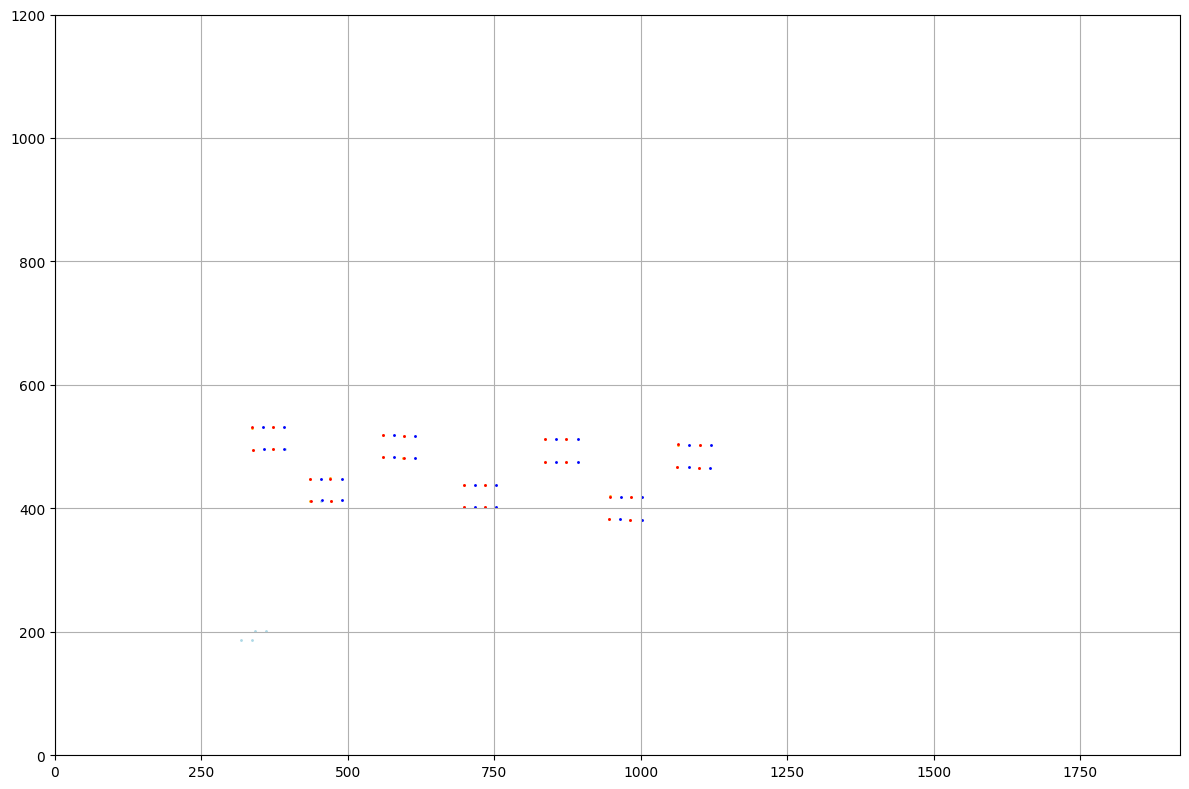

In [9]:
plt.figure(figsize=(12, 8))
plt.rcParams["figure.autolayout"] = True
plt.xlim(0, size[0])
plt.ylim(0, size[1])
plt.grid()

x = left_indirect_rectify_points[:, 0]
y = left_indirect_rectify_points[:, 1]
color = "lightblue"
plt.scatter(x, y, c=color, s = 1)

x = right_indirect_rectify_points[:, 0]
y = right_indirect_rectify_points[:, 1]
color = "orange"
plt.scatter(x, y, c=color, s = 1)

x = left_rectify_points[0, :, 0]
y = left_rectify_points[0, :, 1]
color = "blue"
plt.scatter(x, y, c=color, s = 1)

x = right_rectify_points[0, :, 0]
y = right_rectify_points[0, :, 1]
color = "red"
plt.scatter(x, y, c=color, s = 1)

plt.show()

In [10]:
z_distance_cm = 349

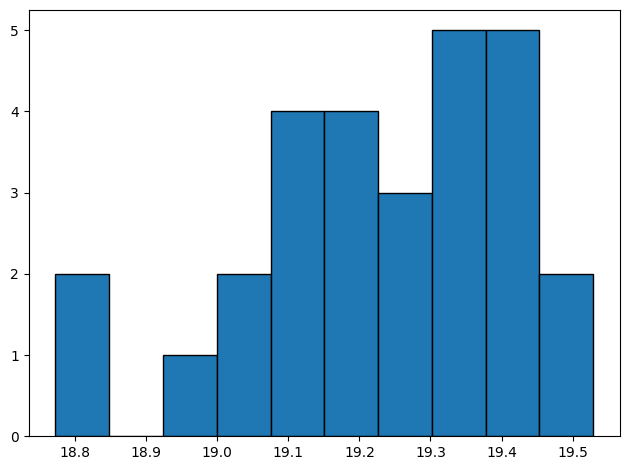

In [11]:
list_disparity_direct = []
list_disparity_indirect = []
for i in range(left_rectify_points.shape[1]):
    list_disparity_direct.append(left_rectify_points[0, i, 0] - right_rectify_points[0, i, 0])
    list_disparity_indirect.append(left_indirect_rectify_points[i, 0] - right_indirect_rectify_points[i, 0])

list_disparity_direct = np.array(list_disparity_direct)
list_disparity_indirect = np.array(list_disparity_indirect)
plt.hist(list_disparity_direct, bins=10, edgecolor='black')
plt.show()

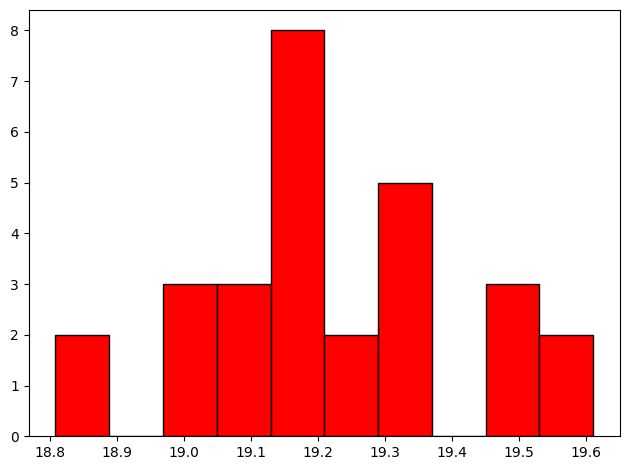

In [12]:
plt.hist(list_disparity_indirect, bins=10, edgecolor='black', color='red')
plt.show()

In [13]:
def dispDepthConverter(disparity): # Does Disparity to Depth or Depth to disparity. 
    return left_t_right[0] * M_focal[0][0] / disparity

print(f' depth at max disparity from the points projection is {dispDepthConverter(np.max(list_disparity_direct))}')
print(f' depth at min disparity from the points projection is {dispDepthConverter(np.min(list_disparity_direct))}')
print(f' depth at median disparity from the points projection is {dispDepthConverter(np.median(list_disparity_direct))}')
print(f'Accuracy at max disparity value of {list_disparity_direct.max()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_direct.max())) / z_distance_cm) * 100}%')
print(f'Accuracy at Min disparity value of {list_disparity_direct.min()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_direct.min())) / z_distance_cm) * 100}%')
print(f'Accuracy at median disparity value of {np.median(list_disparity_direct)} is  Value -> {((z_distance_cm - dispDepthConverter(np.median(list_disparity_direct))) / z_distance_cm) * 100}%')



 depth at max disparity from the points projection is 349.7520034061271
 depth at min disparity from the points projection is 363.8494777081447
 depth at median disparity from the points projection is 354.7810838433412
Accuracy at max disparity value of 19.52886962890625 is  Value -> -0.21547375533727034%
Accuracy at Min disparity value of 18.772216796875 is  Value -> -4.254864672820837%
Accuracy at median disparity value of 19.252044677734375 is  Value -> -1.6564710152840136%


In [14]:
print(f' depth at max disparity from the undistorted image detection is {dispDepthConverter(np.max(list_disparity_indirect))}')
print(f' depth at min disparity from the undistorted image detection is {dispDepthConverter(np.min(list_disparity_indirect))}')
print(f' depth at median disparity from the undistorted image detection is {dispDepthConverter(np.median(list_disparity_indirect))}')
print(f'Accuracy at max disparity value of {list_disparity_indirect.max()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_indirect.max())) / z_distance_cm) * 100}%')
print(f'Accuracy at Min disparity value of {list_disparity_indirect.min()} is  Value -> {((z_distance_cm - dispDepthConverter(list_disparity_indirect.min())) / z_distance_cm) * 100}%')
print(f'Accuracy at median disparity value of {np.median(list_disparity_indirect)} is  Value -> {((z_distance_cm - dispDepthConverter(np.median(list_disparity_indirect))) / z_distance_cm) * 100}%')

def z_error(disp):
    return ((z_distance_cm - dispDepthConverter(disp)) / z_distance_cm) * 100


 depth at max disparity from the undistorted image detection is 348.28955324879615
 depth at min disparity from the undistorted image detection is 363.1463601213911
 depth at median disparity from the undistorted image detection is 355.91820360596
Accuracy at max disparity value of 19.610870361328125 is  Value -> 0.20356640435640308%
Accuracy at Min disparity value of 18.808563232421875 is  Value -> -4.053398315584849%
Accuracy at median disparity value of 19.190536499023438 is  Value -> -1.982293296836677%


In [15]:
for i in range(len(list_disparity_direct)):
    print(f'at id {left_ids[i // 4]} Depth direct is {dispDepthConverter(list_disparity_direct[i])} and undirect is {dispDepthConverter(list_disparity_indirect[i])}')
    

at id [5] Depth direct is 359.24220610939295 and undirect is 359.35641257517136
at id [5] Depth direct is 349.7520034061271 and undirect is 348.28955324879615
at id [5] Depth direct is 363.8494777081447 and undirect is 362.38902979347006
at id [5] Depth direct is 351.411526964446 and undirect is 350.5655241216528
at id [7] Depth direct is 352.93876709967395 and undirect is 354.1674602870755
at id [7] Depth direct is 358.95009899162767 and undirect is 355.9054691578316
at id [7] Depth direct is 359.6803922547491 and undirect is 359.6977338269182
at id [7] Depth direct is 354.6928113806095 and undirect is 355.9439582748702
at id [9] Depth direct is 356.47005476307794 and undirect is 356.3156930267358
at id [9] Depth direct is 357.05921822588033 and undirect is 356.897516422407
at id [9] Depth direct is 353.20277356298334 and undirect is 350.19198571102
at id [9] Depth direct is 352.0449757668149 and undirect is 355.5176469375543
at id [11] Depth direct is 351.4446352673445 and undirect i

## Error closer to left edge

In [21]:
sorted_indices = np.argsort(left_ids[:, 0])
for i in sorted_indices:
    marker_index = i * 4
    print('Next marker ------------------------------------')
    print(f'at id {left_ids[i]} z-error direct is {z_error(list_disparity_direct[marker_index])} and undirect is {z_error(list_disparity_indirect[marker_index])}')
    print(f'at id {left_ids[i]} z-error direct is {z_error(list_disparity_direct[marker_index + 1])} and undirect is {z_error(list_disparity_indirect[marker_index + 1])}')
    print(f'at id {left_ids[i]} z-error direct is {z_error(list_disparity_direct[marker_index + 2])} and undirect is {z_error(list_disparity_indirect[marker_index + 2])}')
    print(f'at id {left_ids[i]} z-error direct is {z_error(list_disparity_direct[marker_index + 3])} and undirect is {z_error(list_disparity_indirect[marker_index + 3])}')


Next marker ------------------------------------
at id [5] z-error direct is -2.9347295442386687 and undirect is -2.9674534599344873
at id [5] z-error direct is -0.21547375533727034 and undirect is 0.20356640435640308
at id [5] z-error direct is -4.254864672820837 and undirect is -3.8363982216246586
at id [5] z-error direct is -0.6909819382366794 and undirect is -0.4485742468919197
Next marker ------------------------------------
at id [6] z-error direct is -4.16731459926246 and undirect is -4.053398315584849
at id [6] z-error direct is -1.6817765770134756 and undirect is -2.520708574068728
at id [6] z-error direct is -2.071649643812813 and undirect is -1.9859423969652925
at id [6] z-error direct is -2.0083292583018895 and undirect is -1.3517014616607843
Next marker ------------------------------------
at id [7] z-error direct is -1.1285865615111614 and undirect is -1.4806476467265124
at id [7] z-error direct is -2.851031229692742 and undirect is -1.978644457831401
at id [7] z-error di